In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindi-english-parallel-corpus/hindi_english_parallel.csv


# AOML Lab
# Experiment - 11


### Divyansh Agarwal
### AIML B-3
### 500076414
### R177219079

In [40]:
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense,TimeDistributed,Embedding,Bidirectional
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from string import digits
import nltk
import re
import string

In [41]:
df = pd.read_csv("/kaggle/input/hindi-english-parallel-corpus/hindi_english_parallel.csv")
df.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [42]:
df.shape

(1561841, 2)

In [43]:
df.isna().sum()

hindi      6056
english     725
dtype: int64

In [44]:
df = df[:85000]

In [45]:
df.shape

(85000, 2)

In [46]:
df.isna().sum()

hindi      3
english    0
dtype: int64

In [47]:
df.dropna(inplace=True)

In [48]:
df.isna().sum()

hindi      0
english    0
dtype: int64

### Preprocessing

In [49]:
# lowercasing
for col in df.columns:
    df[col] = df[col].apply(lambda x: str(x))
    df[col] = df[col].apply(lambda x: x.lower())
print("data converted to lowercase")
print("======================================")
    
# removing stopwords
stop_words = stopwords.words('english')
print("removing stopwords...")
print(stop_words[:10])
df['english'] = df['english'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['hindi'] = df['hindi'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
print("stopwords have been removed!")
print("======================================")

# removing quotes
df['english'] = df['english'].apply(lambda x: re.sub("'", '', x))
df['hindi'] = df['hindi'].apply(lambda x: re.sub("'", '', x))
print("data is now free of any qoutes")
print("sample:", df["english"][0])
print("======================================")

# removing all the special characters
punc = set(string.punctuation)
print("fixing punctuation...")
print(punc)
df['english'] = df['english'].apply(lambda x: ''.join(y for y in x if y not in punc))
df['hindi'] = df['hindi'].apply(lambda x: ''.join(y for y in x if y not in punc))
print("all the special characters have been removed!")
print("======================================")

# removing digits
digits = "1234567890"
remove_digits = str.maketrans('','',digits)
print("removing digits...")
print(remove_digits)
df['english'] = df['english'].apply(lambda x: x.translate(remove_digits))
df['hindi'] = df['hindi'].apply(lambda x: x.translate(remove_digits))
df['hindi'] = df['hindi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
print("all the digits have been removed!")
print("======================================")

# removing extra spaces
df['english'] = df['english'].apply(lambda x: x.strip())
df['hindi'] = df['hindi'].apply(lambda x: x.strip())
df['english'] = df['english'].apply(lambda x: re.sub(" +", " ", x))
df['hindi'] = df['hindi'].apply(lambda x: re.sub(" +", " ", x))
print("extra spaces have been removed!")
print("======================================")

print("clean data:")
df.head(51)

data converted to lowercase
removing stopwords...
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
stopwords have been removed!
data is now free of any qoutes
sample: give application accessibility workout
fixing punctuation...
{'!', '#', '-', ')', '@', ':', '*', '+', '%', '<', '?', '^', '/', '=', '(', ';', ',', "'", '_', '[', '&', '}', '\\', ']', '>', '`', '{', '.', '~', '|', '$', '"'}
all the special characters have been removed!
removing digits...
{49: None, 50: None, 51: None, 52: None, 53: None, 54: None, 55: None, 56: None, 57: None, 48: None}
all the digits have been removed!
extra spaces have been removed!
clean data:


,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,give application accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,accerciser accessibility explorer
2,निचले पटल के लिए डिफोल्ट प्लगइन खाका,default plugin layout bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,default plugin layout top panel
4,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...,list plugins disabled default
5,अवधि को हाइलाइट रकें,highlight duration
6,पहुंचनीय आसंधि नोड को चुनते समय हाइलाइट बक्से ...,duration highlight box selecting accessible nodes
7,सीमांत बोर्डर के रंग को हाइलाइट करें,highlight border color
8,हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता।,color opacity highlight border
9,भराई के रंग को हाइलाइट करें,highlight fill color


### Adding start and end tokens to target sequences

In [50]:
df['hindi'] = df['hindi'].apply(lambda x : 'START_ '+ x + ' _END')
df.head()

,hindi,english
0,START_ अपने अनुप्रयोग को पहुंचनीयता व्यायाम का...,give application accessibility workout
1,START_ एक्सेर्साइसर पहुंचनीयता अन्वेषक _END,accerciser accessibility explorer
2,START_ निचले पटल के लिए डिफोल्ट प्लगइन खाका _END,default plugin layout bottom panel
3,START_ ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका _END,default plugin layout top panel
4,START_ उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप...,list plugins disabled default


### Generating dictionaries

In [51]:
### Get English and Hindi Vocabulary
all_eng_words = set()
for eng in df['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hin_words = set()
for hin in df['hindi']:
    for word in hin.split():
        if word not in all_hin_words:
            all_hin_words.add(word)

In [52]:
all_eng_words

{'se',
 'reconnecting',
 'saves',
 'unreachable',
 'un',
 'orward',
 'dateeditor',
 'gobject',
 'folded',
 'delivery',
 'music',
 'resolution',
 'determines',
 'audience',
 'xml',
 'sender',
 'invalid',
 'took',
 'unfinished',
 'coordinate',
 'track…',
 'tinvalid',
 'popups',
 'indent',
 'armenian',
 'ethod',
 'individual',
 'outbox',
 'lan',
 'mount',
 'perform',
 'provider',
 'association',
 'messages',
 'shortcut',
 'counterc',
 'incognito',
 'now',
 'dismiss',
 'mark',
 'manipulating',
 'monte',
 'appear',
 'bugzilla',
 'luanda',
 'clubs',
 'minimise',
 'm',
 'u',
 'historical',
 'symbolic',
 'xover',
 'point',
 'declaration',
 'replaced',
 'romanian',
 'ok',
 'ps',
 'remaining',
 'welcome',
 'mismatch',
 'length',
 'shrink',
 'limits',
 'clicking',
 'pressing',
 'powered',
 'elm',
 'organi',
 'widespread',
 'reminder',
 'online',
 'http',
 'picture',
 'examine',
 'late',
 'dm',
 'ook',
 'details',
 'www',
 'compute',
 'macarabic',
 'verride',
 'untrusted',
 'manage',
 'lder…',
 'a

In [53]:
all_hin_words

{'अप्रत्याशित',
 'एच',
 'पुनर्संबंध',
 'सृजन',
 'दिनाँक',
 'विभाजक',
 'xml',
 'सतत',
 'individual',
 'आनेवाली',
 'फ़ॉन्टः',
 'u',
 'रिका',
 'ssls',
 'अनुपलब्ध',
 'xover',
 'चलाना',
 'स्लाइडशो',
 'आवरणdisc',
 'संपर्कcategoryname',
 'सूचनाaccepted',
 'picture',
 'करने',
 'सड़क',
 'मार्जिन',
 'क़िस्मrgb',
 'मेटाडेटा',
 'गेलियन',
 'libbalsamailboxpop',
 'रूप',
 'लपेटन',
 'विट्रेट',
 'सारा',
 'start',
 'ट्रेस',
 'ppm',
 'हिससे',
 'प्रश्नः',
 'सोर्सेज़',
 'एपिफेनी',
 'वाकई',
 'संयोजक',
 'libgnomeprintui',
 'आँकड़ा',
 'ठोस',
 'परतें',
 'समस्याओं',
 'हार्डलिंक',
 'स्पष्ट',
 'जायेगे',
 'encountered',
 'ग्रुप',
 'टूटी',
 'फिटनेस',
 'मददः',
 'kbps',
 'सिम्लिफाइड',
 'फ्रेंकलिन',
 'हस्ताक्षरः',
 'सुविधा',
 'मौन',
 'फार्स्ट',
 'आपसे',
 'फ़ॉर्म',
 'जोड़ते',
 'gcrd',
 'पढ़ना',
 'वर्णनicalimp',
 'पृष्ठो',
 'रेकॉर्ड',
 'क्लिक',
 'पूछें',
 'मनमाना',
 'पाज',
 'पदक्रम',
 'rtlpredefinito',
 'प्लगेबल',
 'सोर्स',
 'क्लिपबोर्ड',
 'प्रिन्टर',
 'class',
 'चित्रों',
 'यह',
 'any',
 'ग्नूजनरल',
 'बड़ी',
 'टाइमआउट'

### Adding features to data

In [54]:
df['length_eng'] = df['english'].apply(lambda x:len(x.split(" ")))
df['length_hin'] = df['hindi'].apply(lambda x:len(x.split(" ")))

In [55]:
df.head()

,hindi,english,length_eng,length_hin
0,START_ अपने अनुप्रयोग को पहुंचनीयता व्यायाम का...,give application accessibility workout,4,10
1,START_ एक्सेर्साइसर पहुंचनीयता अन्वेषक _END,accerciser accessibility explorer,3,5
2,START_ निचले पटल के लिए डिफोल्ट प्लगइन खाका _END,default plugin layout bottom panel,5,9
3,START_ ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका _END,default plugin layout top panel,5,9
4,START_ उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप...,list plugins disabled default,4,14


In [56]:
df = df[df['length_eng']<=20]
df = df[df['length_hin']<=20]

In [57]:
max_length_src=max(df['length_hin'])
max_length_tar=max(df['length_eng'])
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hin_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hin_words)

In [58]:
num_decoder_tokens

6999

In [59]:
num_decoder_tokens += 1
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [60]:
input_token_index

{'a': 1,
 'aaiun': 2,
 'ababa': 3,
 'abc': 4,
 'abcdefghijk': 5,
 'abidjan': 6,
 'ability': 7,
 'able': 8,
 'abnormal': 9,
 'abort': 10,
 'aborted': 11,
 'aborting': 12,
 'about': 13,
 'about…': 14,
 'above': 15,
 'absolute': 16,
 'ac': 17,
 'accelerated': 18,
 'acceleration': 19,
 'accelerator': 20,
 'accelerator…': 21,
 'accentuated': 22,
 'accept': 23,
 'acceptable': 24,
 'accepted': 25,
 'accerciser': 26,
 'access': 27,
 'accessed': 28,
 'accessibility': 29,
 'accessible': 30,
 'accessibles': 31,
 'accessing': 32,
 'according': 33,
 'accordion': 34,
 'account': 35,
 'accountapos': 36,
 'accounts': 37,
 'accra': 38,
 'accuracy': 39,
 'accurate': 40,
 'ace': 41,
 'aces': 42,
 'across': 43,
 'act': 44,
 'acti': 45,
 'action': 46,
 'actionable': 47,
 'actions': 48,
 'activatable': 49,
 'activate': 50,
 'activated': 51,
 'activation': 52,
 'active': 53,
 'actor': 54,
 'actors': 55,
 'actual': 56,
 'actually': 57,
 'adak': 58,
 'adapt': 59,
 'adaptation': 60,
 'adaptive': 61,
 'adapts': 

In [61]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())
reverse_input_char_index

{1: 'a',
 2: 'aaiun',
 3: 'ababa',
 4: 'abc',
 5: 'abcdefghijk',
 6: 'abidjan',
 7: 'ability',
 8: 'able',
 9: 'abnormal',
 10: 'abort',
 11: 'aborted',
 12: 'aborting',
 13: 'about',
 14: 'about…',
 15: 'above',
 16: 'absolute',
 17: 'ac',
 18: 'accelerated',
 19: 'acceleration',
 20: 'accelerator',
 21: 'accelerator…',
 22: 'accentuated',
 23: 'accept',
 24: 'acceptable',
 25: 'accepted',
 26: 'accerciser',
 27: 'access',
 28: 'accessed',
 29: 'accessibility',
 30: 'accessible',
 31: 'accessibles',
 32: 'accessing',
 33: 'according',
 34: 'accordion',
 35: 'account',
 36: 'accountapos',
 37: 'accounts',
 38: 'accra',
 39: 'accuracy',
 40: 'accurate',
 41: 'ace',
 42: 'aces',
 43: 'across',
 44: 'act',
 45: 'acti',
 46: 'action',
 47: 'actionable',
 48: 'actions',
 49: 'activatable',
 50: 'activate',
 51: 'activated',
 52: 'activation',
 53: 'active',
 54: 'actor',
 55: 'actors',
 56: 'actual',
 57: 'actually',
 58: 'adak',
 59: 'adapt',
 60: 'adaptation',
 61: 'adaptive',
 62: 'adapt

### Splitting data

In [62]:
X = df['english'] 
y = df['hindi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.006, random_state=101)
print("data has been split!")

data has been split!


In [63]:
encoder_input_data = np.zeros((2, max_length_src),dtype='float32')
decoder_input_data = np.zeros((2, max_length_tar),dtype='float32')
decoder_target_data = np.zeros((2, max_length_tar, num_decoder_tokens),dtype='float32')

In [64]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [65]:
latent_dim = 300
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens+1, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


In [66]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens+1, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [67]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


In [68]:
model.summary()
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 10
epochs = 10


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    1433400     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 300)    2100300     input_4[0][0]                    
____________________________________________________________________________________________

In [69]:
model.save('eng-to-hindi.h5')

In [70]:
a, b = next(generate_batch())

In [71]:
checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
z=model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples/batch_size,
                    epochs=20,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples/batch_size,
                    callbacks = [cp_callback]  
                     )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
8271/8271 [==============================] - 199s 23ms/step - loss: 0.7509 - accuracy: 0.5336 - val_loss: 0.2932 - val_accuracy: 0.7854

Epoch 00001: saving model to ./training_1/cp.ckpt
Epoch 2/20
8271/8271 [==============================] - 186s 23ms/step - loss: 0.1650 - accuracy: 0.8763 - val_loss: 0.1411 - val_accuracy: 0.9039

Epoch 00002: saving model to ./training_1/cp.ckpt
Epoch 3/20
8271/8271 [==============================] - 187s 23ms/step - loss: 0.0866 - accuracy: 0.9301 - val_loss: 0.1182 - val_accuracy: 0.9172

Epoch 00003: saving model to ./training_1/cp.ckpt
Epoch 4/20
8271/8271 [==============================] - 187s 23ms/step - loss: 0.0633 - accuracy: 0.9449 - val_loss: 0.1094 - val_accuracy: 0.9224

Epoch 00004: saving model to ./training_1/cp.ckpt
Epoch 5/20
8271/8271 [==============================] - 187s 23ms/step - loss: 0.0529 - accuracy: 0.9516 - val_loss: 0.0999 - val_accuracy: 0.9277

Epoch 00005: saving model to ./training_1/cp.ckpt
Epoch 6/20

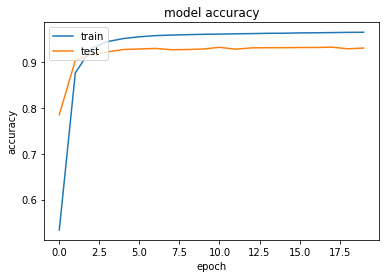

In [72]:
import matplotlib.pyplot as plt
plt.plot(z.history['accuracy'])
plt.plot(z.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

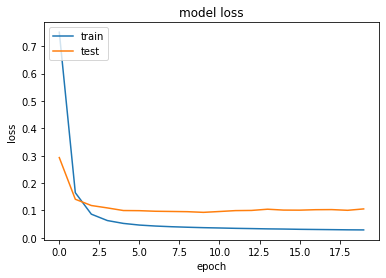

In [73]:
import matplotlib.pyplot as plt
plt.plot(z.history['loss'])
plt.plot(z.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [75]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [76]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

### BLEU Score

In [77]:
from nltk.translate.bleu_score import sentence_bleu
ref = [
    'this is moonlight'.split(),
    'Look, this is moonlight'.split(),
    'moonlight it is'.split()
]
test = 'it is moonlight'.split()
print('BLEU score for test-> {}'.format(sentence_bleu(ref, test)))
 
test01 = 'it is cat and moonlight'.split()
print('BLEU score for test01-> {}'.format(sentence_bleu(ref, test01)))

BLEU score for test-> 1.0
BLEU score for test01-> 0.6223329772884784


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### Prediction

In [121]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: select avatar image
Actual Hindi Translation:  अवतार चित्र चुनें 
Predicted Hindi Translation:  कार्ड थीम “ s” के साथ कार्ड दिखाएं 


In [79]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)

In [80]:
from nltk.translate.bleu_score import sentence_bleu


In [88]:
output=[]
inputz=[]
k=0
for i in range(len(X_test)):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence = decode_sequence(input_seq)
    q=y_test[k:k+1].values[0][6:-4]
    K+=1
    x=decoded_sentence[:-4]
    inputz.append(q)
    output.append(x)    

In [118]:
bleu = 0

for i in range(len(output)):
    bleu += sentence_bleu([inputz[i].split()], output[i].split(), weights = (0.5, 0.5))

print("BLEU score is : ", bleu / len(output))

BLEU score is :  0.014018302415201422


In [119]:
bleu = 0

for i in range(len(output)):
    bleu += sentence_bleu([inputz[i].split()], output[i].split(), weights = (0.5, 0.5))

print("BLEU score is : ", bleu)

BLEU score is :  7.009151207600711


In [122]:
for i in range(10):
    print(output[i],' -> ', inputz[i])

 चुनें   ->   प्रतिः o 
 अंत में जोड़ें को   ->   जैबर id सूची 
 प्रयुक्त के लिए कार्यान्वयन फ़ाइल   ->   ईंट की बेगम 
 प्रमाणपत्र क्रिप्टोग्राफी कमजोर है   ->   स्लाइस करें s 
 फिर वैसे भी लोड करें   ->   headworking copy 
 प्रोफ़ाइल नाम   ->   एकल आयामी मोड 
 अपारिभाषित   ->   क्लाइंट ने ऑपरेशन रद्द कर दिया 
 क्या बाल रूपांतरण गुण सेट है   ->   संदेश के लिए 
 अज्ञात   ->   जब आप सड़क पार करें तो दोनों तरफ देखें 
 अनुमोदन असफल   ->   विसम्मेलन 
